# Using MATLAB with Amazon SageMaker



# Introduction - [Amazon SageMaker](https://aws.amazon.com/sagemaker/)

Amazon SageMaker helps data scientists and developers to prepare, build, train, and deploy high-quality machine learning (ML) models quickly by bringing together a broad set of capabilities purpose-built for ML.

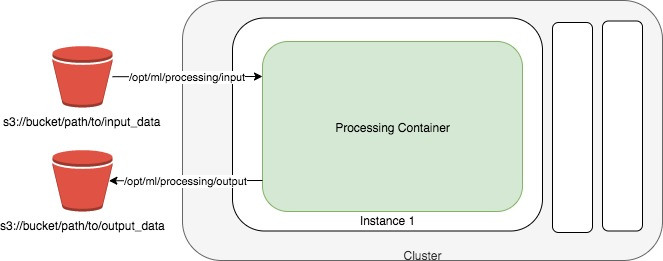

# MATLAB on Amazon SageMaker

With Amazon SageMaker, users can package their own algorithms that can than be trained and deployed in the SageMaker environment. This notebook will guide you through an example that shows you how to build a Docker container for SageMaker with MATLAB and use it for processing, training and inference.

This notebook shows how you can:

1. Build a Docker container with MATLAB by using the official docker hub MATLAB image.  
2. Publish the docker container to Amazon ECR, from where the SageMaker can use it for processing
3. Run a processing job on dataset for preprocessing, training & doing inference on the dataset
4. Get the results back from the processing job inside the SagemMaker instance



# Prerequisites

### Roles and permissions

To get started, we'll import the Python libraries we need, set up the environment with a few prerequisites for permissions and configurations.

In [13]:
from sagemaker import get_execution_role
import pandas as pd
import sagemaker
import boto3
import os
import json

role = get_execution_role()

In [14]:
!mkdir -p /home/ec2-user/SageMaker/docker/
!sudo service docker stop
!sudo mv /var/lib/docker/ /home/ec2-user/SageMaker/docker/
!sudo ln -s /home/ec2-user/SageMaker/docker/ /var/lib/docker
!sudo service docker start

Stopping docker: [  OK  ]
mv: inter-device move failed: ‘/var/lib/docker/’ to ‘/home/ec2-user/SageMaker/docker/docker’; unable to remove target: Directory not empty
ln: ‘/var/lib/docker/docker’: cannot overwrite directory
Starting docker:	.[  OK  ]


### License Manager for MATLAB

Documentation on how to setup the license sever

### Dockerfile & dependencies

In [15]:
!mkdir -p matlab-docker

Create a dockerfile which pulls MATLAB's image from https://hub.docker.com/r/mathworks/matlab-deep-learning and adds a new ENTRYPOINT & CMD

In [20]:
%%writefile matlab-docker/Dockerfile
FROM mathworks/matlab-deep-learning
USER root
CMD ["matlab", "-batch", "cd /opt/ml/processing/input_data; main; exit"]

Overwriting matlab-docker/Dockerfile


## MATLAB docker image on ECR  

Define variables for ECR

In [24]:
account_id = boto3.client('sts').get_caller_identity().get('Account')
region = boto3.Session().region_name
ecr_repository = 'mthakker-refarch2'
tag = ':latest'
processing_repository_uri = '{}.dkr.ecr.{}.amazonaws.com/{}'.format(account_id, region, ecr_repository + tag)

### Create docker image from Dockerfile

In [25]:
# Create ECR repository and push docker image
!docker build -t $ecr_repository matlab-docker/

Sending build context to Docker daemon  4.608kB
Step 1/3 : FROM mathworks/matlab-deep-learning
 ---> 9dc8fda2f365
Step 2/3 : USER root
 ---> Using cache
 ---> 90717be51c51
Step 3/3 : CMD ["matlab", "-batch", "cd /opt/ml/processing/input_data; main; exit"]
open /home/ec2-user/SageMaker/docker/overlay2/d798afdcaf151fb9527ded26f6b84031578eede10c3e48ec6dcde41f8f0e340d/committed: no such file or directory


Authenticate the SageMaker session

In [ ]:
!aws ecr get-login-password --region {region} | docker login --username AWS --password-stdin {account_id}.dkr.ecr.{region}.amazonaws.com
# !aws ecr create-repository --repository-name $ecr_repository

In [ ]:
!docker tag {ecr_repository + tag} $processing_repository_uri

Push MATLAB image to ECR

In [ ]:
!docker push $processing_repository_uri

## SageMaker processor 

Intialize the `sagemaker.processing.Processor` using the following -

1. dwe
2. 
3. 
4. `MLM_LICENSE_FILE` generated via the License Manager for MATLAB

In [9]:
from sagemaker.processing import Processor, ProcessingInput, ProcessingOutput
#replace with your region & ECR repo name

processor = Processor(
    image_uri=processing_repository_uri,
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge", #replace with required instance
    env = {"MLM_LICENSE_FILE":"27000@34.195.26.98"}
)

Set up the S3 bucket that you want to use for getting the dataset

In [10]:
import boto3
bucketname = 'mthakker-example-dataset' # replace with your bucket name
filename = 'DigitDataset.zip' # replace with your object key
s3 = boto3.client('s3')
s3.download_file(bucketname,filename,"DigitDataset.zip")


### Write the MATLAB script `main.m` 

The training code is written in the file “main.m” which is uploaded in the /opt/ml/processing/input_data/ directory of the docker processing container. 

In [11]:
%%writefile main.m
tic
disp("starting the Deep Learning Example")
disp(pwd)

digitDatasetPath = fullfile('/opt/ml/processing/train_data/', 'DigitDataset');
unzip(digitDatasetPath, '/opt/ml/processing/train_data/')
imds = imageDatastore(digitDatasetPath, ...
    'IncludeSubfolders',true,'LabelSource','foldernames');

disp("dataset loaded in memory")

labelCount = countEachLabel(imds)


numTrainFiles = 750;
[imdsTrain,imdsValidation] = splitEachLabel(imds,numTrainFiles,'randomize');

layers = [
    imageInputLayer([28 28 1])

    convolution2dLayer(3,8,'Padding','same')
    batchNormalizationLayer
    reluLayer

    maxPooling2dLayer(2,'Stride',2)

    convolution2dLayer(3,16,'Padding','same')
    batchNormalizationLayer
    reluLayer

    maxPooling2dLayer(2,'Stride',2)

    convolution2dLayer(3,32,'Padding','same')
    batchNormalizationLayer
    reluLayer

    fullyConnectedLayer(10)
    softmaxLayer
    classificationLayer];

options = trainingOptions('sgdm', ...
    'InitialLearnRate',0.01, ...
    'MaxEpochs',4, ...
    'Shuffle','every-epoch', ...
    'ValidationData',imdsValidation, ...
    'ValidationFrequency',30, ...
    'Verbose',false, ...
    'Plots','training-progress');

disp("Training started")

net = trainNetwork(imdsTrain,layers,options);

disp("Training finsished")

YPred = classify(net,imdsValidation);
YValidation = imdsValidation.Labels;

accuracy = 100*(sum(YPred == YValidation)/numel(YValidation));
toc
disp("Accuracy - " + string(accuracy))

try
    fileID = fopen('/opt/ml/processing/output_data/results.txt','w');
    disp(fileID)
    if fileID==-1
        disp("cannot open file properly")
    else
        fprintf(fileID,'Accuracy - %g\n', accuracy);
        fclose(fileID);
    end
catch
    disp("error saving file to output")
end

Overwriting main.m


Uploading `main.m` script and `DigitDataset.zip` file from SageMaker instance to docker processing container

In [ ]:
%%time
processor.run(
    inputs=
    [ProcessingInput(
        source='/home/ec2-user/SageMaker/main.m',
        destination='/opt/ml/processing/input_data/'),
     ProcessingInput(
        source='/home/ec2-user/SageMaker/DigitDataset.zip',
        destination='/opt/ml/processing/train_data/'),
    ],
    outputs = [
        ProcessingOutput(
            output_name="results",
            source="/opt/ml/processing/output_data",
        ),
    ]
)



Job Name:  mthakker-refarch-2021-11-18-12-47-32-744
Inputs:  [{'InputName': 'input-1', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-951215880850/mthakker-refarch-2021-11-18-12-47-32-744/input/input-1/main.m', 'LocalPath': '/opt/ml/processing/input_data/', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'input-2', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-951215880850/mthakker-refarch-2021-11-18-12-47-32-744/input/input-2/DigitDataset.zip', 'LocalPath': '/opt/ml/processing/train_data/', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'results', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-951215880850/mthakker-refarch-2021-11-18-12-47-32-744/output/results', 'LocalPath': '/opt/ml/processing/output_data', 'S3UploadMode': 'En

### Getting results back from docker processing container to SageMaker instance

In [ ]:
preprocessing_job_description = processor.jobs[-1].describe()
output_config = preprocessing_job_description["ProcessingOutputConfig"]

In [ ]:
s3_output_dir = output_config['Outputs'][0]['S3Output']['S3Uri']
s3_result = os.path.join(s3_output_dir, "results.txt")

In [ ]:
print(pd.read_csv(s3_result, header=None)[0][0])